# Compute Regions with similar seasonal cycles and variance

In [5]:
#using ClusterBGC
using Compat
using CABLAB
using MultivariateAnomalies
using RecurrenceAnalysis

Path to cube

In [2]:
c=Cube("/Net/Groups/BGI/scratch/DataCube/v0.2.0/low-res")

CABLAB data cube at /Net/Groups/BGI/scratch/DataCube/v0.2.0/low-res
Spatial resolution:  1440x720 at 0.25 degrees.
Temporal resolution: 2001-01-01T00:00:00 to 2012-01-01T00:00:00 at 8daily time steps
Variables:           Rg aerosol_optical_thickness_1610 aerosol_optical_thickness_550 aerosol_optical_thickness_555 aerosol_optical_thickness_659 aerosol_optical_thickness_865 air_temperature_2m bare_soil_evaporation black_sky_albedo burnt_area c_emissions country_mask evaporation evaporative_stress fpar_fluxcom fractional_snow_cover gross_primary_productivity interception_loss land_surface_temperature latent_energy net_ecosystem_exchange open_water_evaporation ozone potential_evaporation precipitation root_moisture sensible_heat snow_sublimation snow_water_equivalent soil_moisture surface_moisture terrestrial_ecosystem_respiration transpiration water_mask water_vapour white_sky_albedo 


In [3]:
variables = ["fpar_fluxcom", "gross_primary_productivity", "latent_energy", "sensible_heat"]
variables2 = ["air_temperature_2m","Rg", "precipitation"]
cdata = getCubeData(c,variable=c.dataset_files,longitude=(-10,35),latitude=(-30,65),variable=variables)
cdata2 = getCubeData(c,variable=c.dataset_files,longitude=(-10,35),latitude=(-30,65),variable=variables2)
#cdata_orig=getCubeData(c,variable=c.dataset_files,variable=variables);

In [4]:
VAR = 7
MAX_CACHE = 1.0e9

1.0e9

In [6]:
@everywhere function scaleCubeQuantiles(xout::AbstractVector,xin::AbstractVector,quantiles)
    absm=(abs(quantiles[1]-quantiles[3])+abs(quantiles[2]-quantiles[3]))/2
    for i in eachindex(xin)
        xout[i]=(xin[i]-quantiles[3])/absm # x - median(x) / (mean(abs(quant))
    end
end

In [7]:
# register scaleCubeQuantiles for Time and MSCAxis
registerDATFunction(scaleCubeQuantiles,
((TimeAxis,),(CategoricalAxis{Float64,:Quantile},)),
                   (TimeAxis,),
                   inmissing  = (:nan,:nan),
                   outmissing = :nan,
                   no_ocean   = 1)
# register Version of mwVAR
registerDATFunction(mw_VAR!,(TimeAxis,VariableAxis),(TimeAxis,VariableAxis),inmissing=(:nan,),outmissing=:nan,no_ocean=1)

CABLAB.DAT.DATFunction(((CABLAB.Cubes.Axes.RangeAxis{DateTime,:Time,CABLAB.Cubes.Axes.YearStepRange},CABLAB.Cubes.Axes.CategoricalAxis{String,:Variable}),),(CABLAB.Cubes.Axes.RangeAxis{DateTime,:Time,CABLAB.Cubes.Axes.YearStepRange},CABLAB.Cubes.Axes.CategoricalAxis{String,:Variable}),(),Any,(:nan,),:nan,1,true,zero,identity,"auto")

In [8]:
# register timespacequantile
registerDATFunction(CABLAB.Proc.Stats.timespacequantiles,(TimeAxis,SpatialPointAxis),
  ((cube,pargs)->begin
    length(pargs)==0 ? CategoricalAxis("Quantile",[0.25,0.5,0.75]) : CategoricalAxis("Quantile",pargs[1])
  end,),
  (cube,pargs)->begin
    tax=getAxis(TimeAxis,cube[1])
    sax=getAxis(SpatialPointAxis,cube[1])
    return length(pargs)==1 ? pargs[1] : [0.25,0.5,0.75],zeros(eltype(cube[1]),length(tax),length(sax))
  end,inmissing=(:nan,),outmissing=:nan)

CABLAB.DAT.DATFunction(((CABLAB.Cubes.Axes.RangeAxis{DateTime,:Time,CABLAB.Cubes.Axes.YearStepRange},CABLAB.Cubes.Axes.CategoricalAxis{Tuple{Float64,Float64},:SpatialPoint}),),(#22,),#23,Any,(:nan,),:nan,0,true,zero,identity,"auto")

In [9]:
# gap fill cube
@time cdata = mapCube(gapFillMSC, cdata, max_cache=MAX_CACHE);
@time cdata2 = mapCube(gapFillMSC, cdata2, max_cache=MAX_CACHE);

 49.391032 seconds (583.97 M allocations: 14.049 GB, 4.99% gc time)
 29.538047 seconds (426.19 M allocations: 10.061 GB, 6.73% gc time)


- local variables

In [10]:
@time cdata_rmMSC = mapCube(removeMSC, cdata, max_cache=MAX_CACHE);
@time cdata_rmMSC2 = mapCube(removeMSC, cdata2, max_cache=MAX_CACHE);

 29.960887 seconds (564.54 M allocations: 11.435 GB, 6.35% gc time)
 21.701431 seconds (423.29 M allocations: 8.571 GB, 6.39% gc time)


In [11]:
#addprocs(4)
#CABLAB.DAT.init_DATworkers()

In [12]:
@everywhere function getAMI!(xout, xin, lags)
    if(!any(isnan(xin)))
        mutual = ami(xin, lags)
        copy!(xout, mutual)
        xout[end] = Float32(lags[find(mutual .== minimum(mutual))[1]])
    else 
        xout[1] = NaN
        xout[end] = NaN
    end
    return(xout)
end
@everywhere function createMIAxis(lags)
    CategoricalAxis("MutualInformation",[["Mi$i" for i=lags];"MinLag"])
    #CategoricalAxis("MutualInformation",["Mi$i" for i=lags])
end
@everywhere inAxes = (TimeAxis,)
@everywhere outAxes = ((cube, pargs)->createMIAxis(pargs[1]),)

In [13]:
registerDATFunction(getAMI!,inAxes,outAxes,inmissing=(:nan,:nan),outmissing=:nan,no_ocean=1)

CABLAB.DAT.DATFunction(((CABLAB.Cubes.Axes.RangeAxis{DateTime,:Time,CABLAB.Cubes.Axes.YearStepRange},),),(#44,),(),Any,(:nan,:nan),:nan,1,true,zero,identity,"auto")

In [14]:
@time MutualInfo = mapCube(getAMI!, cdata, 3:3:30)

 98.764201 seconds (61.18 M allocations: 21.310 GB, 3.66% gc time)


Temporary Data Cube with the following dimensions
MutualInformation   Axis with elements: Mi3 Mi6 Mi9 Mi12 Mi15 Mi18 Mi21 Mi24 Mi27 Mi30 MinLag 
Lon                 Axis with 180 Elements from -10.0 to 34.75
Lat                 Axis with 380 Elements from 65.0 to -29.75
Variable            Axis with elements: fpar_fluxcom gross_primary_productivity latent_energy sensible_heat 


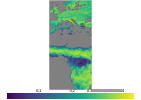

In [48]:
using Colors
plotMAP(MutualInfo, colorm = com, mut=1,var=2)

In [16]:
@everywhere using MultivariateAnomalies
@everywhere using RecurrenceAnalysis

In [17]:
@everywhere function getRecurrenceMetrics!(xout, xin, Dtmp, DeltaT = 12, DIM = 3, RR = 0.05)
    if(!any(isnan(xin)))
        x = (xin .- mean(xin, 1)) ./ std(xin, 1)
        embedded = TDE(x, DeltaT, DIM)
        dist_matrix!(Dtmp, embedded)
        eps = quantile(unsafe_wrap(Array, pointer(Dtmp[1]), length(Dtmp[1])), RR)
        rmat = sparse(Dtmp[1] .<= eps)
        xout[1] = determinism(rmat)
        xout[2] = entropy(rmat)
        xout[3] = trend(rmat)[1]
        xout[4] = laminarity(rmat)
        xout[5] = trappingtime(rmat)
    else 
        xout[1] = NaN; xout[2] = NaN; xout[3] = NaN; xout[4] = NaN;
    end
    return(xout)
end

In [18]:
@everywhere inAxes = ((TimeAxis, VariableAxis),)
@everywhere outAxes = (CategoricalAxis("RecurrenceMetrics",["Determinism", "Entropy", "Trend", "Laminarity", "TrappingTime"]), )

In [19]:
@everywhere VAR = 7
@everywhere DIM = 3
@everywhere DeltaT = 12
@everywhere Dtmp = init_dist_matrix(TDE(randn(506, VAR), DeltaT, DIM))

In [20]:
registerDATFunction(getRecurrenceMetrics!,inAxes,outAxes,inmissing=(:nan,:nan),outmissing=:nan,no_ocean=1)

CABLAB.DAT.DATFunction(((CABLAB.Cubes.Axes.RangeAxis{DateTime,:Time,CABLAB.Cubes.Axes.YearStepRange},CABLAB.Cubes.Axes.CategoricalAxis{String,:Variable}),),(RecurrenceMetrics   Axis with elements: Determinism Entropy Trend Laminarity TrappingTime ,),(),Any,(:nan,:nan),:nan,1,true,zero,identity,"auto")

In [21]:
@time RecMetCube = mapCube(getRecurrenceMetrics!, cdata, Dtmp, DeltaT, DIM, max_cache = MAX_CACHE)
@time RecMetCube2 = mapCube(getRecurrenceMetrics!, cdata2, Dtmp, DeltaT, DIM, max_cache = MAX_CACHE)

904.703571 seconds (93.13 M allocations: 119.610 GB, 2.68% gc time)
1208.790037 seconds (116.81 M allocations: 161.344 GB, 2.53% gc time)


In-Memory data cube with the following dimensions
RecurrenceMetrics   Axis with elements: Determinism Entropy Trend Laminarity TrappingTime 
Lon                 Axis with 180 Elements from -10.0 to 34.75
Lat                 Axis with 380 Elements from 65.0 to -29.75


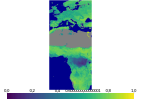

In [37]:
using Colors
using PlotUtils
com = [cgrad(:viridis)[x] for x in linspace(0,1,100)]
plotMAP(RecMetCube, colorm = com, dmin = 0.0, dmax = 1.0,rec=1) # Biosphere

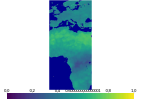

In [36]:
plotMAP(RecMetCube2, colorm = com,dmin = 0.0, dmax = 1.0,rec=1) # Atmosphere

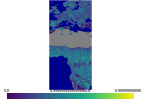

In [45]:
plotMAP(RecMetCube, colorm = com,dmin=0.0,dmax=1e-5,rec=3) # Biosphere